# Asset Portfolio Management using Deep Reinforcement Learning
---

## 6 Backtesting and Evaluation of the Portfolios

### 6.1 Import Relevant Packages

In [1]:
import numpy as np 
import pandas as pd 
import pyfolio as pf
from pyfolio import timeseries
import matplotlib.pyplot as plt
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot, backtest_strat, baseline_strat
import seaborn as sns

sns.set()

C:\Users\Musonda\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 6.2 Load the Train and Test Data for Portfolios

In [3]:
%store -r max_sharpe_portfolio
%store -r uniform_weights_port

%store -r prices_train_df
%store -r prices_test_df


%store -r a2c_train_daily_return
%store -r ppo_train_daily_return
%store -r ddpg_train_daily_return

%store -r a2c_test_returns 
%store -r ppo_test_returns 
%store -r ddpg_test_returns 

In [4]:
returns_train = prices_train_df.pct_change() # get the assets daily returns
returns_test = prices_test_df.pct_change()

# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_returns = returns_train.dot(uw_weights)
uw_cum_returns = (1 + uw_returns).cumprod()
uw_cum_returns.name = "portfolio 1: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_returns = returns_train.dot(max_sharpe_weights)
max_sharpe_cum_returns = (1 + max_sharpe_returns).cumprod()
max_sharpe_cum_returns.name = "portfolio 2: max sharpe"

a2c_train_cum_returns = (1 + a2c_train_daily_return['daily_return']).cumprod()
a2c_train_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_train_cum_returns = (1 + ppo_train_daily_return['daily_return']).cumprod()
ppo_train_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_train_cum_returns = (1 + ddpg_train_daily_return['daily_return']).cumprod()
ddpg_train_cum_returns.name = 'Portfolio 5: ddpg Model'


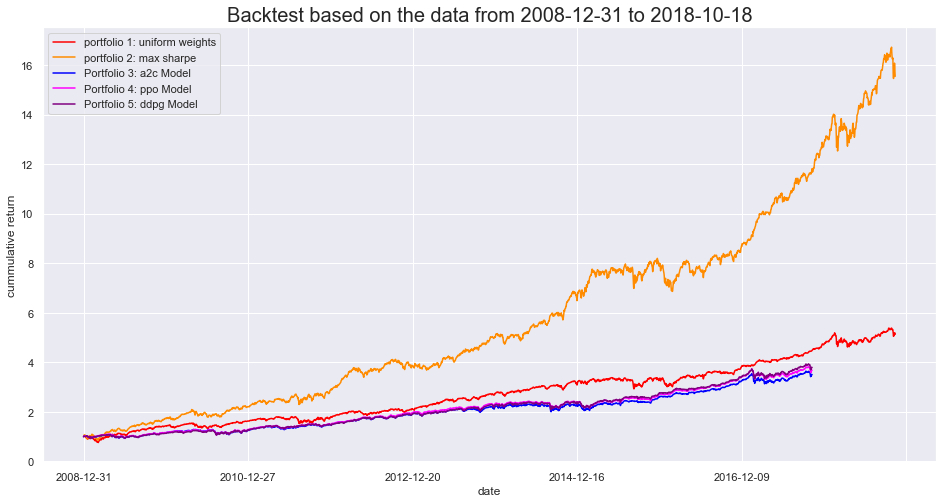

In [9]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(16,8))
uw_cum_returns.plot(ax=ax, color="red");
max_sharpe_cum_returns.plot(ax=ax, color="darkorange");

a2c_train_cum_returns.plot(ax=ax, color='blue')
ppo_train_cum_returns.plot(ax=ax, color='magenta')
ddpg_train_cum_returns.plot(ax=ax, color='purple')

plt.legend(loc="best");
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2008-12-31 to 2018-10-18", fontsize=20);
fig.savefig('results/back_test_on_train_data.png');

### 6.4 Evaluating the Portfolios on Test Data

In [10]:
# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_test_returns = returns_test.dot(uw_weights)
uw_test_cum_returns = (1 + uw_test_returns).cumprod()
uw_test_cum_returns.name = "portfolio 1: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_test_returns = returns_test.dot(max_sharpe_weights)
max_sharpe_test_cum_returns = (1 + max_sharpe_test_returns).cumprod()
max_sharpe_test_cum_returns.name = "portfolio 2: max sharpe"

a2c_test_cum_returns = (1 + a2c_test_returns['daily_return']).cumprod()
a2c_test_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_test_cum_returns = (1 + ppo_test_returns['daily_return']).cumprod()
ppo_test_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_test_cum_returns = (1 + ddpg_test_returns['daily_return']).cumprod()
ddpg_test_cum_returns.name = 'Portfolio 5: ddpg Model'

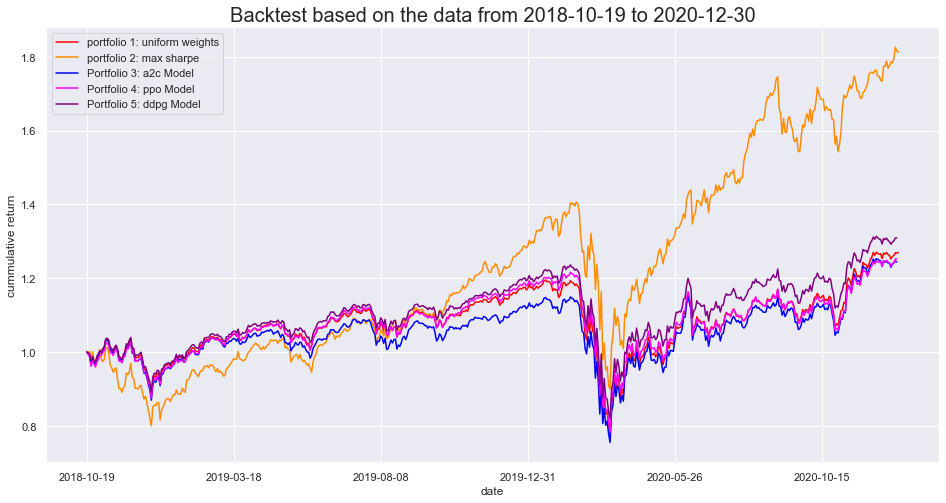

In [12]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(16,8))
uw_test_cum_returns.plot(ax=ax, color="red");
max_sharpe_test_cum_returns.plot(ax=ax, color="darkorange");
a2c_test_cum_returns.plot(ax=ax, color='blue')
ppo_test_cum_returns.plot(ax=ax, color='magenta')
ddpg_test_cum_returns.plot(ax=ax, color='purple')
plt.legend(loc="best");
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2018-10-19 to 2020-12-30", fontsize=20);
fig.savefig('results/back_test_on_test_data.png');

### 6.5 Get the Portfolio Statistics

In [13]:
# Define a Function for Getting the Portfolio Statistics

def portfolio_stats(portfolio_returns):
    # Pass the returns into a dataframe
    port_rets_df = pd.DataFrame(portfolio_returns)
    port_rets_df = port_rets_df.reset_index()
    port_rets_df.columns = ['date','daily_return']
    
    #Use the FinRL Library to get the Portfolio Returns
    #This makes use of the Pyfolio Library
    
    DRL_strat = backtest_strat(port_rets_df)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                                  factor_returns=DRL_strat, 
                                    positions=None, transactions=None, turnover_denom="AGB")
    perf_stats_all = pd.DataFrame( perf_stats_all)
    perf_stats_all.columns = ['Statistic']
    return perf_stats_all

In [14]:
uw_test_returns.shape

(553,)

In [15]:
# Get the Portfolio Statistics for all the portfolios
portfolios_returns_dict = {'uniform_weights':uw_test_returns, 'maximum_sharpe':max_sharpe_test_returns,
                          'a2c Model': a2c_test_returns['daily_return'],
                          'ppo Model': ppo_test_returns['daily_return'],
                          'ddpg Model': ddpg_test_returns['daily_return']}

portfolios_stats = pd.DataFrame()
for i,j in portfolios_returns_dict.items():
    port_stats = portfolio_stats(j)
    portfolios_stats[i] = port_stats['Statistic']

In [16]:
portfolios_stats

,uniform_weights,maximum_sharpe,a2c Model,ppo Model,ddpg Model
Annual return,0.115238,0.311253,0.104784,0.108145,0.130845
Cumulative returns,0.270414,0.812411,0.243936,0.252241,0.309116
Annual volatility,0.267247,0.313526,0.269676,0.271480,0.260585
Sharpe ratio,0.542897,1.024413,0.504612,0.514467,0.602832
Calmar ratio,0.329296,0.861999,0.304996,0.303600,0.387869
Stability,0.273031,0.874904,0.255291,0.282144,0.443333
Max drawdown,-0.349952,-0.361083,-0.343559,-0.356208,-0.337343
Omega ratio,1.122007,1.237497,1.111406,1.116073,1.138399
Sortino ratio,0.764795,1.435566,0.714969,0.723065,0.846306
Skew,NaN,NaN,-0.149398,-0.268227,-0.401762


### 6.6 Benchmarking the Best Portfolio against the Benchmark Index

In [17]:
#a2c_test_returns = a2c_test_returns.set_index('date')
ppo_test_returns = ppo_test_returns.set_index('date')
ddpg_test_returns = ddpg_test_returns.set_index('date')

In [18]:
a2c_test_returns.head()

,date,daily_return
0,2018-10-19,0.000000
1,2018-10-22,-0.005321
2,2018-10-23,-0.006090
3,2018-10-24,-0.024084
4,2018-10-25,0.015915


In [19]:
# Getting the best performing portfolio

ps_cum = [a2c_test_cum_returns, ppo_test_cum_returns,ddpg_test_cum_returns]
ps = [a2c_test_returns['daily_return'], ppo_test_returns['daily_return'], ddpg_test_returns['daily_return']]

final_return = []
for p in ps_cum:
    final_return.append(p.iloc[-1])
    
id_ = np.argmax(final_return)
best_p = ps[id_]
best_p.name = (ps_cum[id_]).name 

print("Best portfolio: ",  best_p.name)
print("Final cumulative return: {:.2f} ".format(final_return[id_]))

Best portfolio:  Portfolio 5: ddpg Model
Final cumulative return: 1.31 


In [20]:
# convert the best portfolio into a Dataframe

best_p = pd.DataFrame(best_p)
best_p = best_p.reset_index()
best_p.columns=['date','daily_return']

In [21]:
best_p.head()

,date,daily_return
0,2018-10-19,0.000000
1,2018-10-22,-0.002456
2,2018-10-23,-0.002109
3,2018-10-24,-0.021786
4,2018-10-25,0.014597


In [22]:
# Best portfolio stats
best_port_strat = backtest_strat(best_p)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=best_port_strat, 
                              factor_returns=best_port_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [23]:
prices_test_dates = list(prices_test_df.index)

print("==============Get Index Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = prices_test_dates[0],
                                  baseline_end = prices_test_dates[-1])

==============Get Index Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (553, 7)
Annual return          0.084684
Cumulative returns     0.195285
Annual volatility      0.272511
Sharpe ratio           0.436007
Calmar ratio           0.228345
Stability              0.170450
Max drawdown          -0.370862
Omega ratio            1.097979
Sortino ratio          0.599949
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.857623
Daily value at risk   -0.033862
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [24]:
dji, dow_strat = baseline_strat('^DJI',prices_test_dates[1], prices_test_dates[-1])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (551, 7)


Start date,2018-10-22
End date,2020-12-29
Total months,26
,Backtest
Annual return,13.11%
Cumulative returns,30.912%
Annual volatility,26.082%
Sharpe ratio,0.60
Calmar ratio,0.39
Stability,0.44
Max drawdown,-33.734%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.73,2020-02-12,2020-03-23,2020-11-10,195
1,14.40,2018-12-03,2018-12-24,2019-02-20,58
2,6.40,2019-07-29,2019-08-14,2019-09-13,35
3,5.62,2019-04-30,2019-05-31,2019-06-18,36
4,5.59,2018-11-08,2018-11-23,2018-12-03,18


C:\Users\Musonda\anaconda3\lib\site-packages\pyfolio\tears.py:906: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn('Passed returns do not overlap with any'


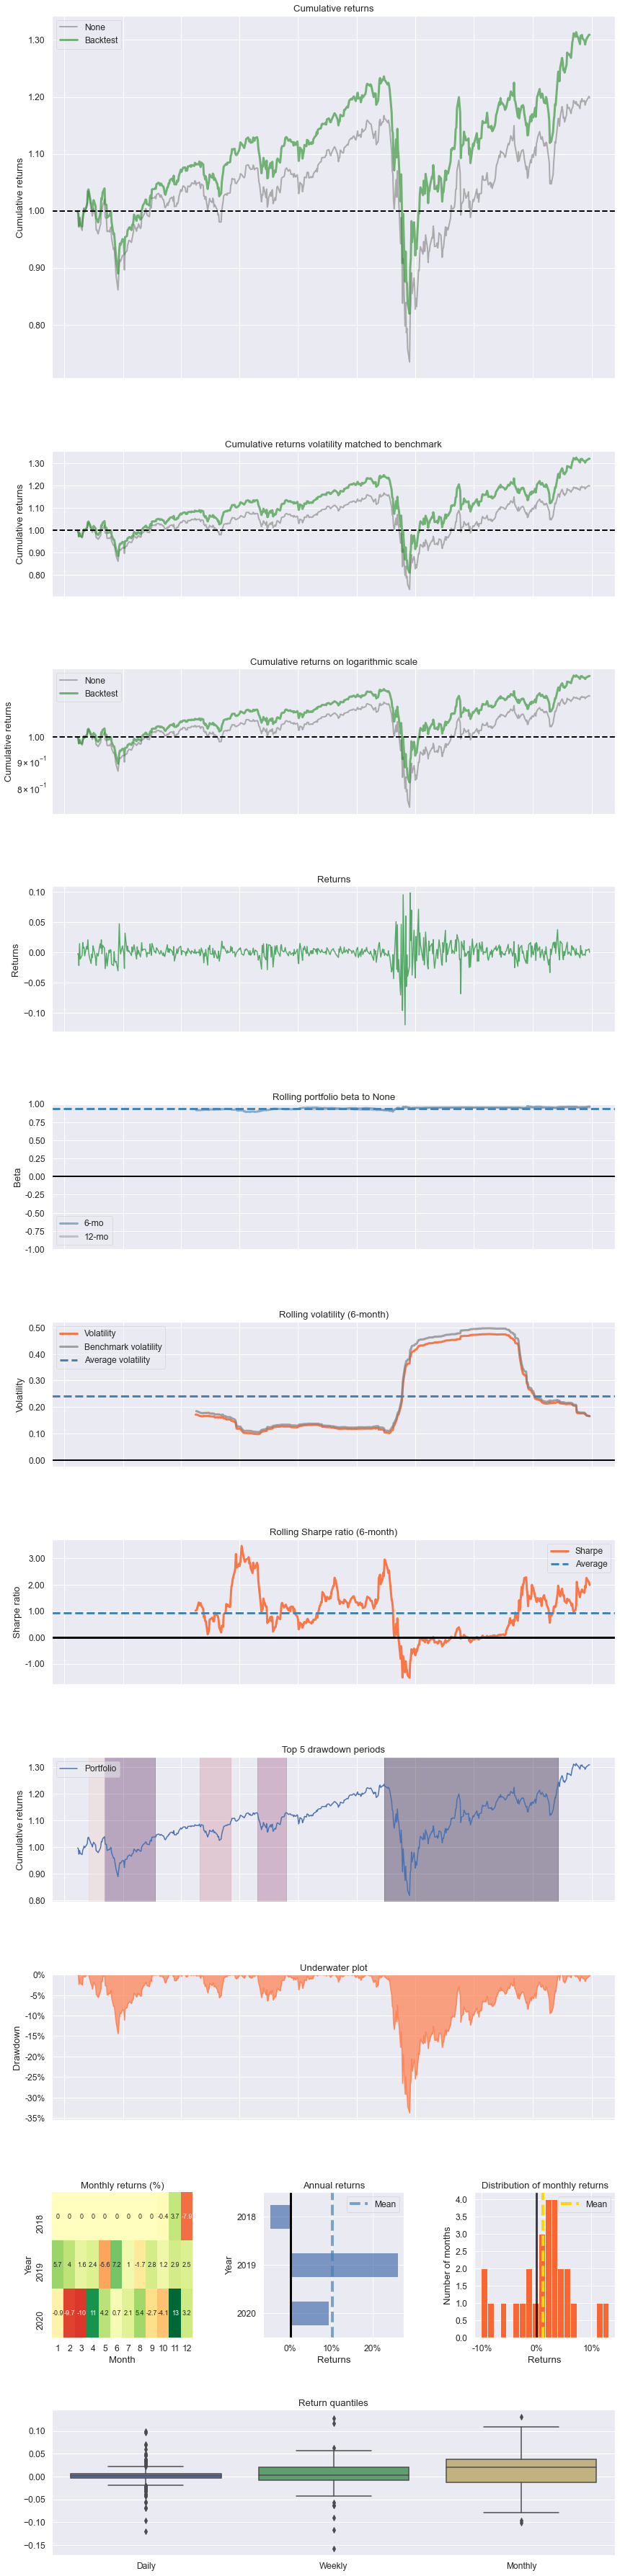

In [25]:
# Get the Benchmarking Plots
import pyfolio
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = best_port_strat,
                                       benchmark_rets=dow_strat, set_context=False)